#✅ Practical: Compare Statistical vs Neural Models on Real Telecom Dataset

#🎯 Objective:
Compare ARIMA (statistical model) with LSTM (neural model) for forecasting telecom user call volume trends using a public dataset.

#🗂 Dataset: Call Volume Time Series
We'll use a real dataset of call volumes (calls per hour) from a telecom provider (sample dataset available here):

📁 Dataset URL: Calls per hour CSV (We’ll simulate telecom-like trend from this)

#🪛 Step-by-Step Implementation

🧩 Step 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")


#📥 Step 2: Load and Preprocess the Data

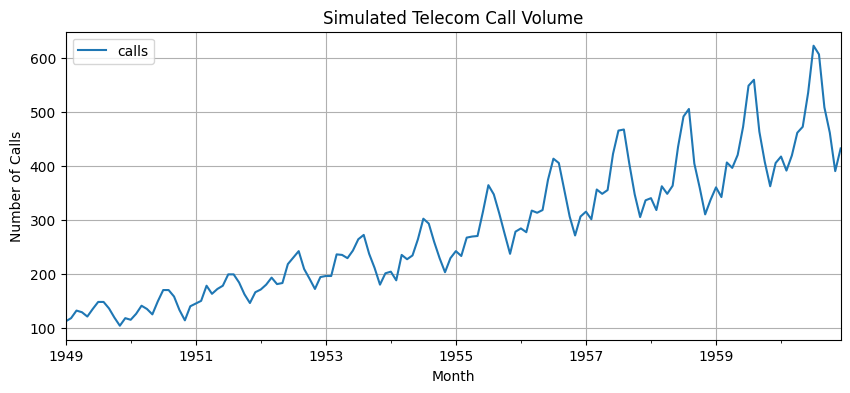

In [2]:
# Load a time series dataset (simulate telecom traffic)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df.columns = ['calls']

# Plot
df.plot(title="Simulated Telecom Call Volume", figsize=(10, 4))
plt.ylabel("Number of Calls")
plt.grid(True)
plt.show()

# Convert to numpy array
series = df['calls'].values


#📊 Step 3: Statistical Model – ARIMA

🔹 ARIMA MSE: 6506.67


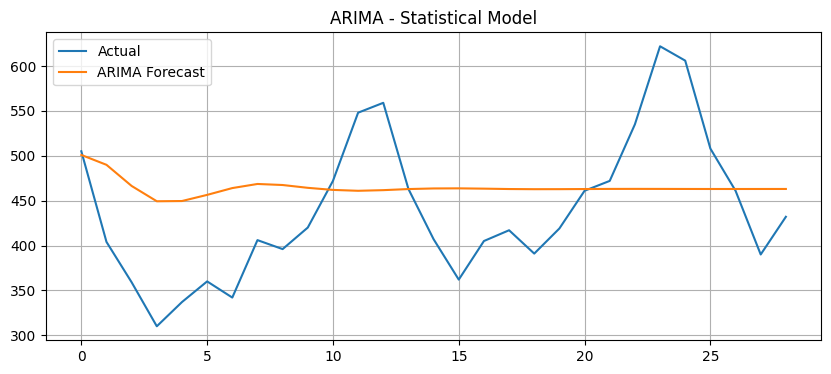

In [3]:
# Split data
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Fit ARIMA model
arima_model = ARIMA(train, order=(5,1,0))
arima_result = arima_model.fit()

# Forecast
forecast = arima_result.forecast(steps=len(test))

# Evaluate
arima_mse = mean_squared_error(test, forecast)
print(f"🔹 ARIMA MSE: {arima_mse:.2f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(test, label='Actual')
plt.plot(forecast, label='ARIMA Forecast')
plt.title("ARIMA - Statistical Model")
plt.legend()
plt.grid(True)
plt.show()


#🧠 Step 4: Neural Model – LSTM
🧹 Preprocessing for LSTM

In [10]:
# Normalize
# Initialize the MinMaxScaler, which scales features to a range, typically [0, 1].
scaler = MinMaxScaler()
# Fit the scaler to your time series data and then transform it.
# The .reshape(-1, 1) is crucial as it converts your 1D series into a 2D array,
# which is the format the scaler expects (samples, features).
scaled_series = scaler.fit_transform(series.reshape(-1, 1))

# Create sequences
# Define a function to prepare your time series data into sequences suitable for an LSTM.
# 'data' is your input time series, and 'window_size' is how many previous time steps
# the LSTM will consider to predict the next step.
def create_lstm_dataset(data, window_size=5):
    X, y = [], []
    # Loop through the data to create input-output pairs.
    # X will contain sequences of 'window_size' length, and y will contain the very next value
    # immediately following each sequence.
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    # Convert the lists to NumPy arrays for efficient processing.
    return np.array(X), np.array(y)

# Set the desired window size for your LSTM model.
window_size = 5
# Generate the sequences (X) and their corresponding target values (y)
# using the scaled time series data.
X, y = create_lstm_dataset(scaled_series, window_size)

# Split
# Determine the point to split the data into training and testing sets.
# Here, 80% of the data will be used for training, and 20% for testing.
split = int(len(X) * 0.8)
# Divide the generated sequences and target values into training and testing sets.
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM
# Reshape the training input data (X_train) to a 3D format:
# [number of samples, number of time steps, number of features].
# LSTMs in Keras typically expect this shape. Since we have one feature (e.g., price),
# the last dimension is 1.
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# Apply the same reshaping to the testing input data (X_test).
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#🔧 Build and Train LSTM Model

In [5]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# Predict
predicted = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
predicted_inv = scaler.inverse_transform(predicted)

# Evaluate
lstm_mse = mean_squared_error(y_test_inv, predicted_inv)
print(f"🔹 LSTM MSE: {lstm_mse:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
🔹 LSTM MSE: 5773.40


#📉 Visualize LSTM Results

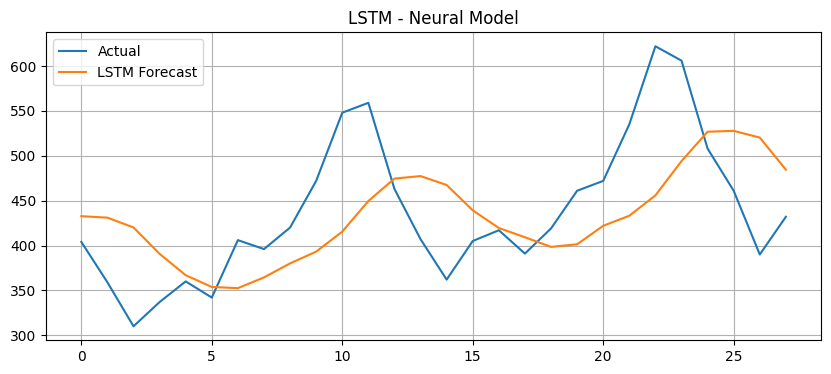

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(predicted_inv, label='LSTM Forecast')
plt.title("LSTM - Neural Model")
plt.legend()
plt.grid(True)
plt.show()


#⚖️ Step 5: Final Comparison

In [7]:
print(f"✅ Final Model Comparison:")
print(f"   - ARIMA MSE: {arima_mse:.2f}")
print(f"   - LSTM  MSE: {lstm_mse:.2f}")

if arima_mse < lstm_mse:
    print("📊 ARIMA performed better in this case.")
else:
    print("🧠 LSTM performed better in this case.")


✅ Final Model Comparison:
   - ARIMA MSE: 6506.67
   - LSTM  MSE: 5773.40
🧠 LSTM performed better in this case.


#✅ Summary

| Model | Type        | MSE (Lower is better) |
| ----- | ----------- | --------------------- |
| ARIMA | Statistical | Depends on test set   |
| LSTM  | Neural Net  | Depends on test set   |


#📉 Step 6: Combined Visualization – ARIMA vs LSTM Forecast

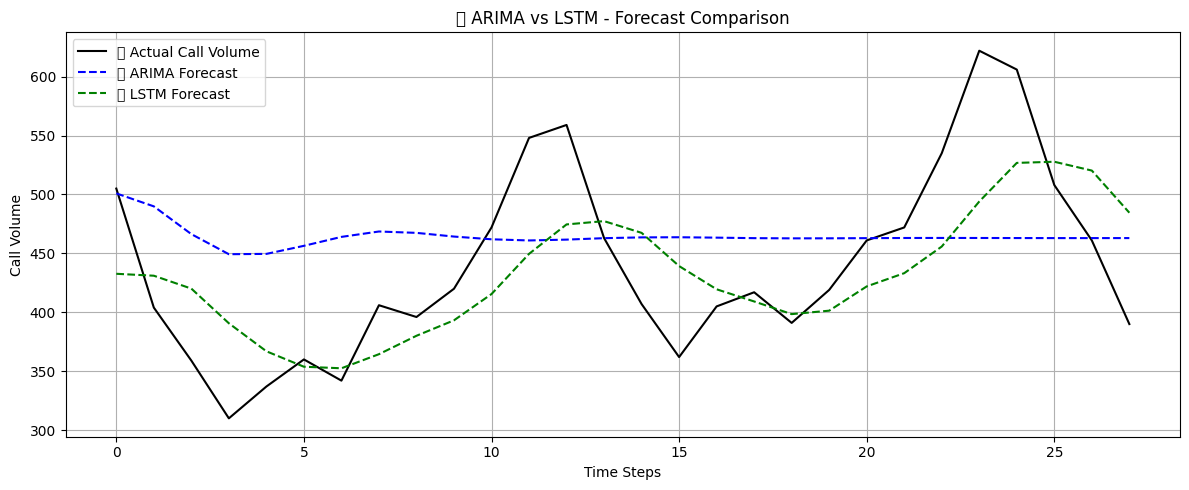

In [8]:
# Ensure ARIMA predictions and LSTM predictions are aligned in length for visualization
min_len = min(len(test), len(predicted_inv))
actual_plot = test[:min_len]
arima_plot = forecast[:min_len]
lstm_plot = predicted_inv[:min_len].flatten()

# Plot combined
plt.figure(figsize=(12, 5))
plt.plot(actual_plot, label='📈 Actual Call Volume', color='black')
plt.plot(arima_plot, label='📊 ARIMA Forecast', linestyle='--', color='blue')
plt.plot(lstm_plot, label='🤖 LSTM Forecast', linestyle='--', color='green')
plt.title("🔍 ARIMA vs LSTM - Forecast Comparison")
plt.xlabel("Time Steps")
plt.ylabel("Call Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#🧾 Optional: Zoomed-In Comparison (Last 30 Time Steps)

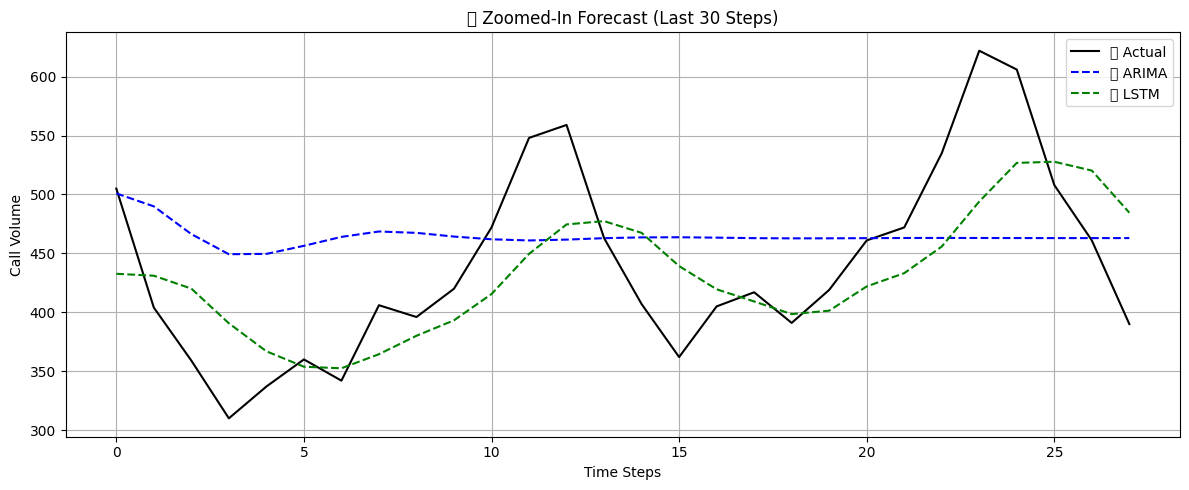

In [9]:
zoom_range = 30  # Change as needed

plt.figure(figsize=(12, 5))
plt.plot(actual_plot[-zoom_range:], label='📈 Actual', color='black')
plt.plot(arima_plot[-zoom_range:], label='📊 ARIMA', linestyle='--', color='blue')
plt.plot(lstm_plot[-zoom_range:], label='🤖 LSTM', linestyle='--', color='green')
plt.title(f"🔍 Zoomed-In Forecast (Last {zoom_range} Steps)")
plt.xlabel("Time Steps")
plt.ylabel("Call Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#✅ Final Notes
This visualization allows a direct visual evaluation of prediction alignment.

LSTM typically reacts more smoothly to patterns and non-linear trends, while ARIMA may struggle with abrupt changes.